<a href="https://colab.research.google.com/github/daj10/Seg_Multimodal_SimpleITK/blob/main/Seg_img_multimodale_SimpleITK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation d'image multimodale avec Python et SimpleITK

> Segmentation 3D

---
*   Les images par résonance magnétique (RM) offrent un excellent contraste dans les tissus mous, par exemple les muscles, la matière cérébrale, etc., anatomies à peine visibles avec la tomodensitométrie(CT)

*   Les CT fournissent une représentation très claire des structures osseuses.
*   Les images pondérées différemment et des agents de contraste différents représentent les mêmes anatomies avec des intensités différentes
*   La matière grise apparaît plus sombre que la matière blanche dans les images pondérées en T1 mais considérablement plus brillante que la matière blanche dans les images pondérées en T2.
*   La segmentation multimodale s'appuie essentiellement sur le fait que nous avons plusieurs images de la même anatomie et permet une segmentation plus précise et souvent plus rapide d'une anatomie.
---

In [33]:
pip install SimpleITK

### Importation

In [36]:
import os
import numpy as np
import SimpleITK as stk
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Fonction pour tracer rapidement une image 2D SimpleITK avec une palette de couleurs en niveaux de gris et les axes associés

In [37]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = stk.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

### Chemins d'acces aux fichiers Mha

In [38]:
filenameT1 = "/content/drive/My Drive/Multimodal_SimpleITK_seg/patient_109/mr_T1/patient_109_mr_T1.mhd"
filenameT2 = "/content/drive/My Drive/Multimodal_SimpleITK_seg/patient_109/mr_T2/patient_109_mr_T2.mhd"

### Index des tranches à visualiser avec 'sitk_show'.

In [39]:
idxSlice = 26

### Etiquette d'entier à attribuer à la matière grise segmentée

In [40]:
labelGrayMatter = 1

## Lecture des images

>**stk.Tile** regroupe plusieurs images d'entrée en une seule image de sortie en utilisant une disposition spécifiée par l'utilisateur


> **stk.Tile**  ne fonctionne que sur des images à un seul composant, c'est-à-dire des images avec une valeur par pixel.

In [56]:
imgT1Original = stk.ReadImage(filenameT1)
imgT2Original = stk.ReadImage(filenameT2)

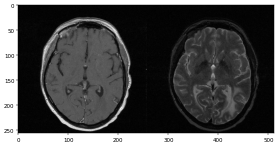

In [45]:
sitk_show(stk.Tile(imgT1Original[:, :, idxSlice],
                         imgT2Original[:, :, idxSlice],
                         (2, 1, 0)))

## Lissage / Debruitage

In [48]:
imgT1Smooth = stk.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgT2Smooth = stk.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

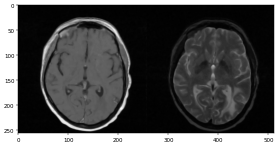

In [50]:
sitk_show(stk.Tile(imgT1Smooth[:, :, idxSlice], 
                         imgT2Smooth[:, :, idxSlice], 
                         (2, 1, 0)))

## Definition point de semance

In [51]:
lstSeeds = [(165, 178, idxSlice),
            (98, 165, idxSlice),
            (205, 125, idxSlice),
            (173, 205, idxSlice)]



> **stk.Image** fait une copie en profondeur des imgT2Smooth dans les imgSeeds, ce qui  permet de ruiner les seconds sans affecter les premiers.






In [52]:
imgSeeds = stk.Image(imgT2Smooth)

In [54]:
for s in lstSeeds:
    imgSeeds[s] = 10000

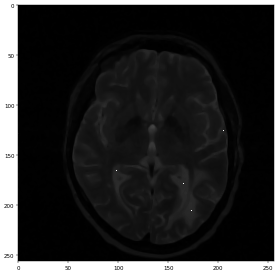

In [55]:
sitk_show(imgSeeds[:, :, idxSlice])

**NB** : l'ordre d'index dans SimpleITK est l'inverse de celui de NumPy



> **sitk_tile_vec** trier de multiples images multicomposantes (vectorielles)


> La fonction prend une liste d'images multi-composants, dans notre cas une liste d'images où nous superposons l'étiquette segmentée, les tuiles et utiliser la **sitk_show** pour afficher le résultat


> **GetNumberOfComponentsPerPixel** méthode de la SimpleITK.Image classe, nous parcours les différents composants de chaque image



> **VectorIndexSelectionCast** extraire une image à un seul composant à laquelle nous ajoutons lstImgToTile.


> **Compose** crée une seule image à plusieurs composants des images à un seul composant en mosaïque.








In [58]:
def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(stk.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(stk.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    sitk_show(stk.Compose(lstImgToCompose))

## Segmentation unimodale

>  **ConfidenceConnected** filtre qui extrait un ensemble connecté de pixels dont les intensités de pixels sont cohérentes avec les statistiques de pixels d'un point de départ» 



In [60]:
imgGrayMatterT1 = stk.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT2 = stk.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.5,
                                                replaceValue=labelGrayMatter)

In [62]:
imgT1SmoothInt = stk.Cast(stk.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgT2SmoothInt = stk.Cast(stk.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())

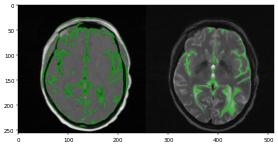

In [63]:
sitk_tile_vec([stk.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT1[:,:,idxSlice]),
               stk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterT2[:,:,idxSlice])])

## Segmentation multimodale

> En combinant les images T1 et T2, nous obtenons deux vues significativement différentes de la matière grise et des zones qui n'étaient pas connectées dans l'une des images peuvent être connectées dans l'autre

> **VectorConfidenceConnected** effectue l'opération sur une image vectorielle, c'est-à-dire une image avec plusieurs composants par pixel 





In [64]:
imgComp = stk.Compose(imgT1Smooth, imgT2Smooth)

In [66]:
imgGrayMatterComp = stk.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)

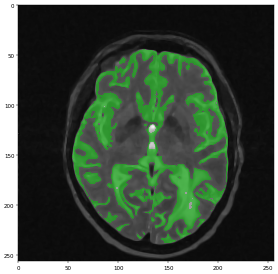

In [67]:
sitk_show(stk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                 imgGrayMatterComp[:,:,idxSlice]))

In [68]:
stk.WriteImage(imgGrayMatterComp, "GrayMatter.mhd")